In [10]:
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip

--2023-01-11 04:43:14--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.218.65.67, 52.218.109.176, 52.218.104.75, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.218.65.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240847944 (230M) [application/octet-stream]
Saving to: ‘5y9wdsg2zt-2.zip’

5y9wdsg2zt-2.zip    100%[===================>] 229.69M  29.1MB/s    in 8.7s    

2023-01-11 04:43:23 (26.5 MB/s) - ‘5y9wdsg2zt-2.zip’ saved [240847944/240847944]



In [13]:
!unzip "5y9wdsg2zt-2.zip" 

Archive:  5y9wdsg2zt-2.zip
replace Concrete Crack Images for Classification.rar? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Concrete Crack Images for Classification.rar  


In [16]:
!unrar x 'Concrete Crack Images for Classification.rar'

Streaming output truncated to the last 5000 lines.
Extracting  Negative/15002.jpg                                            88%  OK 
Extracting  Negative/15003.jpg                                            88%  OK 
Extracting  Negative/15004.jpg                                            88%  OK 
Extracting  Negative/15005.jpg                                            88%  OK 
Extracting  Negative/15006.jpg                                            88%  OK 
Extracting  Negative/15007.jpg                                            88%  OK 
Extracting  Negative/15008.jpg                                            88%  OK 
Extracting  Negative/15009.jpg                                            88%  OK 
Extracting  Negative/15010.jpg                                            88%  OK 
Extracting  Negative/15011.jpg                                            88%  OK 
Extracting  Negative/15012.jp

In [63]:
from tensorflow.keras import layers,optimizers,losses,metrics,callbacks,applications
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from keras.utils import plot_model
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import os, datetime
import splitfolders
import pandas as pd
import numpy as np


In [17]:
#1. Data Loading
PATH = os.path.join(os.getcwd(), 'dataset')

In [19]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
splitfolders.ratio('/content/dataset', output="data", seed=1337, ratio=(.7, 0.2,0.1)) 

Copying files: 40000 files [00:07, 5574.65 files/s]


In [21]:
#2. Data preparation
#(A) Define the path to the train and validation data folder
train_path = '/content/data/train'
val_path = '/content/data/val'
test_path = '/content/data/test'

#(B) Define the batch size and image size
BATCH_SIZE = 32
IMG_SIZE = (160,160)

#(C) Load the data into tensorflow dataset using the specific method
train_dataset = keras.utils.image_dataset_from_directory(train_path,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)
val_dataset = keras.utils.image_dataset_from_directory(val_path,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)


Found 28000 files belonging to 2 classes.
Found 8000 files belonging to 2 classes.


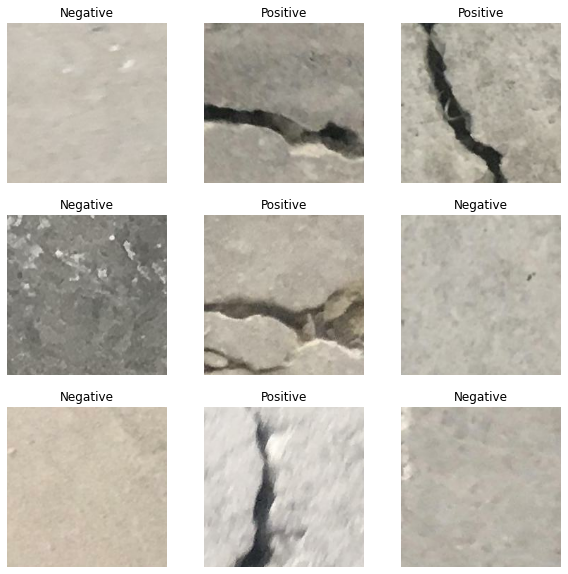

In [23]:
#3. Display some images as example
class_names = train_dataset.class_names

plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(9):
      plt.subplot(3,3,i+1)
      plt.imshow(images[i].numpy().astype('uint8'))
      plt.title(class_names[labels[i]])
      plt.axis('off')

In [24]:
#4. Further split the validation dataset into validation-test split
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches//5)
validation_dataset = val_dataset.skip(val_batches//5)

In [25]:
#5. Convert the BatchDataset into PrefetchDataset
AUTOTUNE = tf.data.AUTOTUNE

pf_train = train_dataset.prefetch(buffer_size=AUTOTUNE)
pf_val = validation_dataset.prefetch(buffer_size=AUTOTUNE)
pf_test = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [27]:
#6. Create a small pipeline for data augmentation
data_augmentation = keras.Sequential()
data_augmentation.add(layers.RandomFlip('horizontal'))
data_augmentation.add(layers.RandomRotation(0.2))

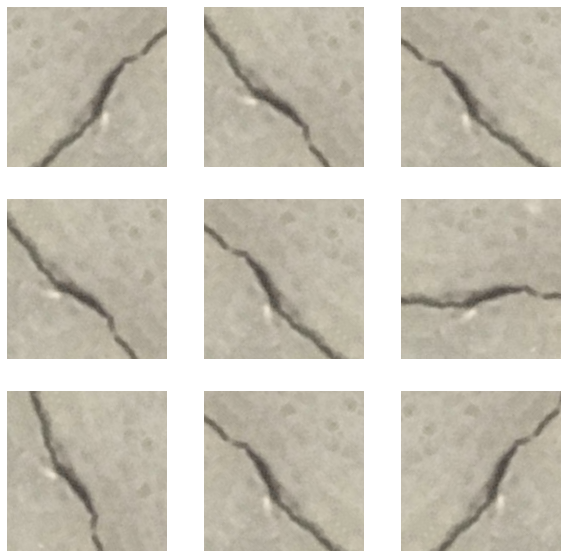

In [28]:
#Apply the data augmentation to test it out
for images,labels in pf_train.take(1):
    first_image = images[0]
    plt.figure(figsize=(10,10))
    for i in range(9):
      plt.subplot(3,3,i+1)
      augmented_image = data_augmentation(tf.expand_dims(first_image,axis=0))
      plt.imshow(augmented_image[0]/255.0)
      plt.axis('off')

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

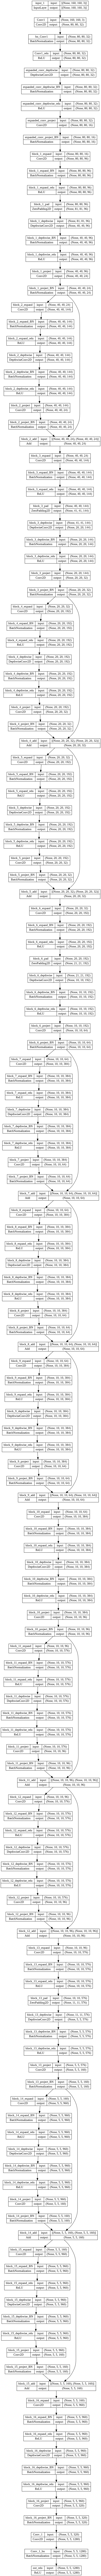

In [29]:
#7. Prepare the layer for data preprocessing
preprocess_input = applications.mobilenet_v2.preprocess_input

#8. Apply transfer learning
IMG_SHAPE = IMG_SIZE + (3,)
feature_extractor = applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

#Disable the training for the feature extractor (freeze the layers)
feature_extractor.trainable = False
feature_extractor.summary()
keras.utils.plot_model(feature_extractor,show_shapes=True)

In [30]:
#9. Create the classification layers
global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(len(class_names),activation='softmax')

In [31]:
#10. Use functional API to link all of the modules together
inputs = keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = feature_extractor(x)
x = global_avg(x)
x = layers.Dropout(0.3)(x)
outputs = output_layer(x)

model = keras.Model(inputs=inputs,outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [32]:
#11. Compile the model
optimizer = optimizers.Adam(learning_rate=0.0001)
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

In [33]:
#Evaluate the model before model training
loss0,accuracy0 = model.evaluate(pf_val)
print("Loss = ",loss0)
print("Accuracy = ",accuracy0)

200/200 [==============================] - 124s 599ms/step - loss: 0.7463 - accuracy: 0.6053
Loss =  0.7462643980979919
Accuracy =  0.6053125262260437


In [36]:
log_path = os.path.join('log_dir','tl_demo',datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tb = callbacks.TensorBoard(log_dir=log_path)
es = EarlyStopping(monitor='val_loss',patience=5,verbose=0,restore_best_weights=True)

#12. Train the model
history = model.fit(pf_train,validation_data=pf_val,epochs=5,callbacks=[tb,es])

Epoch 1/5
875/875 [==============================] - 728s 827ms/step - loss: 0.0756 - accuracy: 0.9753 - val_loss: 0.0152 - val_accuracy: 0.9959
Epoch 2/5
875/875 [==============================] - 740s 846ms/step - loss: 0.0149 - accuracy: 0.9958 - val_loss: 0.0103 - val_accuracy: 0.9966
Epoch 3/5
875/875 [==============================] - 728s 832ms/step - loss: 0.0106 - accuracy: 0.9971 - val_loss: 0.0084 - val_accuracy: 0.9973
Epoch 4/5
875/875 [==============================] - 737s 842ms/step - loss: 0.0092 - accuracy: 0.9971 - val_loss: 0.0071 - val_accuracy: 0.9977
Epoch 5/5
875/875 [==============================] - 743s 850ms/step - loss: 0.0077 - accuracy: 0.9975 - val_loss: 0.0068 - val_accuracy: 0.9975


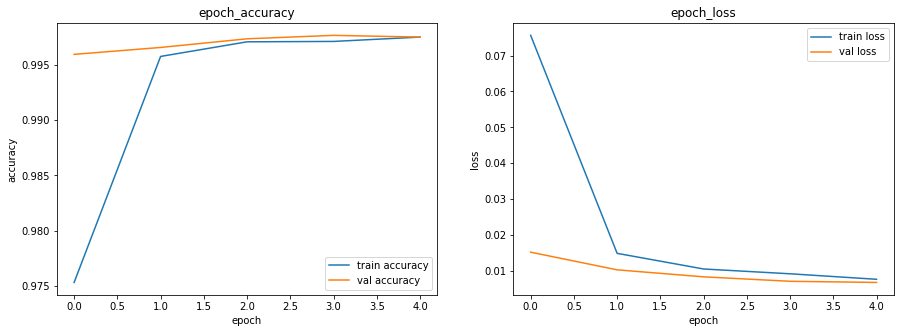

In [56]:
#Visualization
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(acc, label='train accuracy')
plt.plot(val_acc, label='val accuracy')
plt.title('epoch_accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.title('epoch_loss')
plt.legend()
plt.show()


In [57]:
#13. Evaluate the final model
test_loss,test_acc = model.evaluate(pf_test)

print("Loss = ",test_loss)
print("Accuracy = ",test_acc)

50/50 [==============================] - 28s 560ms/step - loss: 0.0058 - accuracy: 0.9975
Loss =  0.005765783600509167
Accuracy =  0.9975000023841858


In [58]:
#14. Model deployment
#Deploy the model using the test data
image_batch, label_batch = pf_test.as_numpy_iterator().next()
predictions = np.argmax(model.predict(image_batch),axis=1)

#Compare label and prediction
label_vs_prediction = np.transpose(np.vstack((label_batch,predictions)))

1/1 [==============================] - 1s 564ms/step


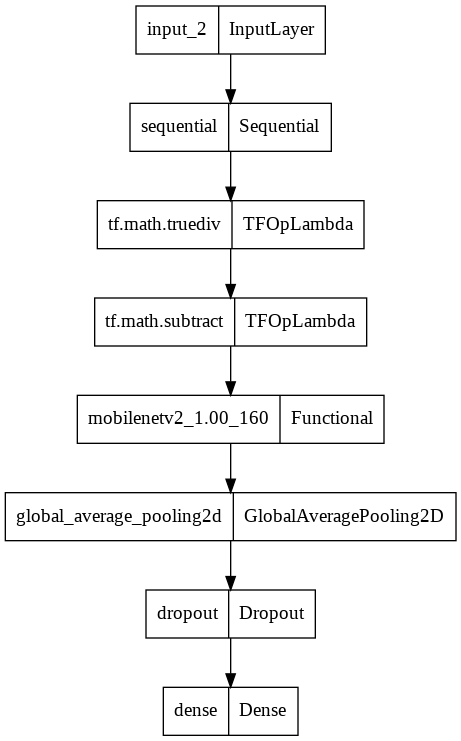

In [59]:
#15. Model saving

#to save trained model
model.save('model.h5')

#To save model architecture
plot_model(model, to_file='model.png')
